In [44]:
import sys
import warnings
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
import os
import random

if not sys.warnoptions:
    warnings.simplefilter('ignore')
tf.compat.v1.disable_eager_execution()
tf.random.set_random_seed(1234)

In [45]:
# Load and prepare data
df = pd.read_csv(r'C:\Users\HP\Downloads\vn100_prices.csv', parse_dates=['TradingDate'])
columns_to_choose = [col for col in df.columns if col != 'TradingDate']

# Choose 5 random columns
random_columns = random.sample(columns_to_choose, 5)
random_columns

['PTB', 'ANV', 'VRE', 'GMD', 'CRE']

In [46]:
# Parameters
simulation_size = 1
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 5 # set to 150 for better results
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01
attention_units = 128
results = []

Simulation 1 for column: PTB


train loop: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s, acc=93.7, cost=0.0126]


Simulation 1 for column: ANV


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s, acc=92.8, cost=0.018] 


Simulation 1 for column: VRE


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s, acc=90.1, cost=0.0254]


Simulation 1 for column: GMD


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s, acc=92.4, cost=0.0208] 


Simulation 1 for column: CRE


train loop: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s, acc=92.4, cost=0.0181]


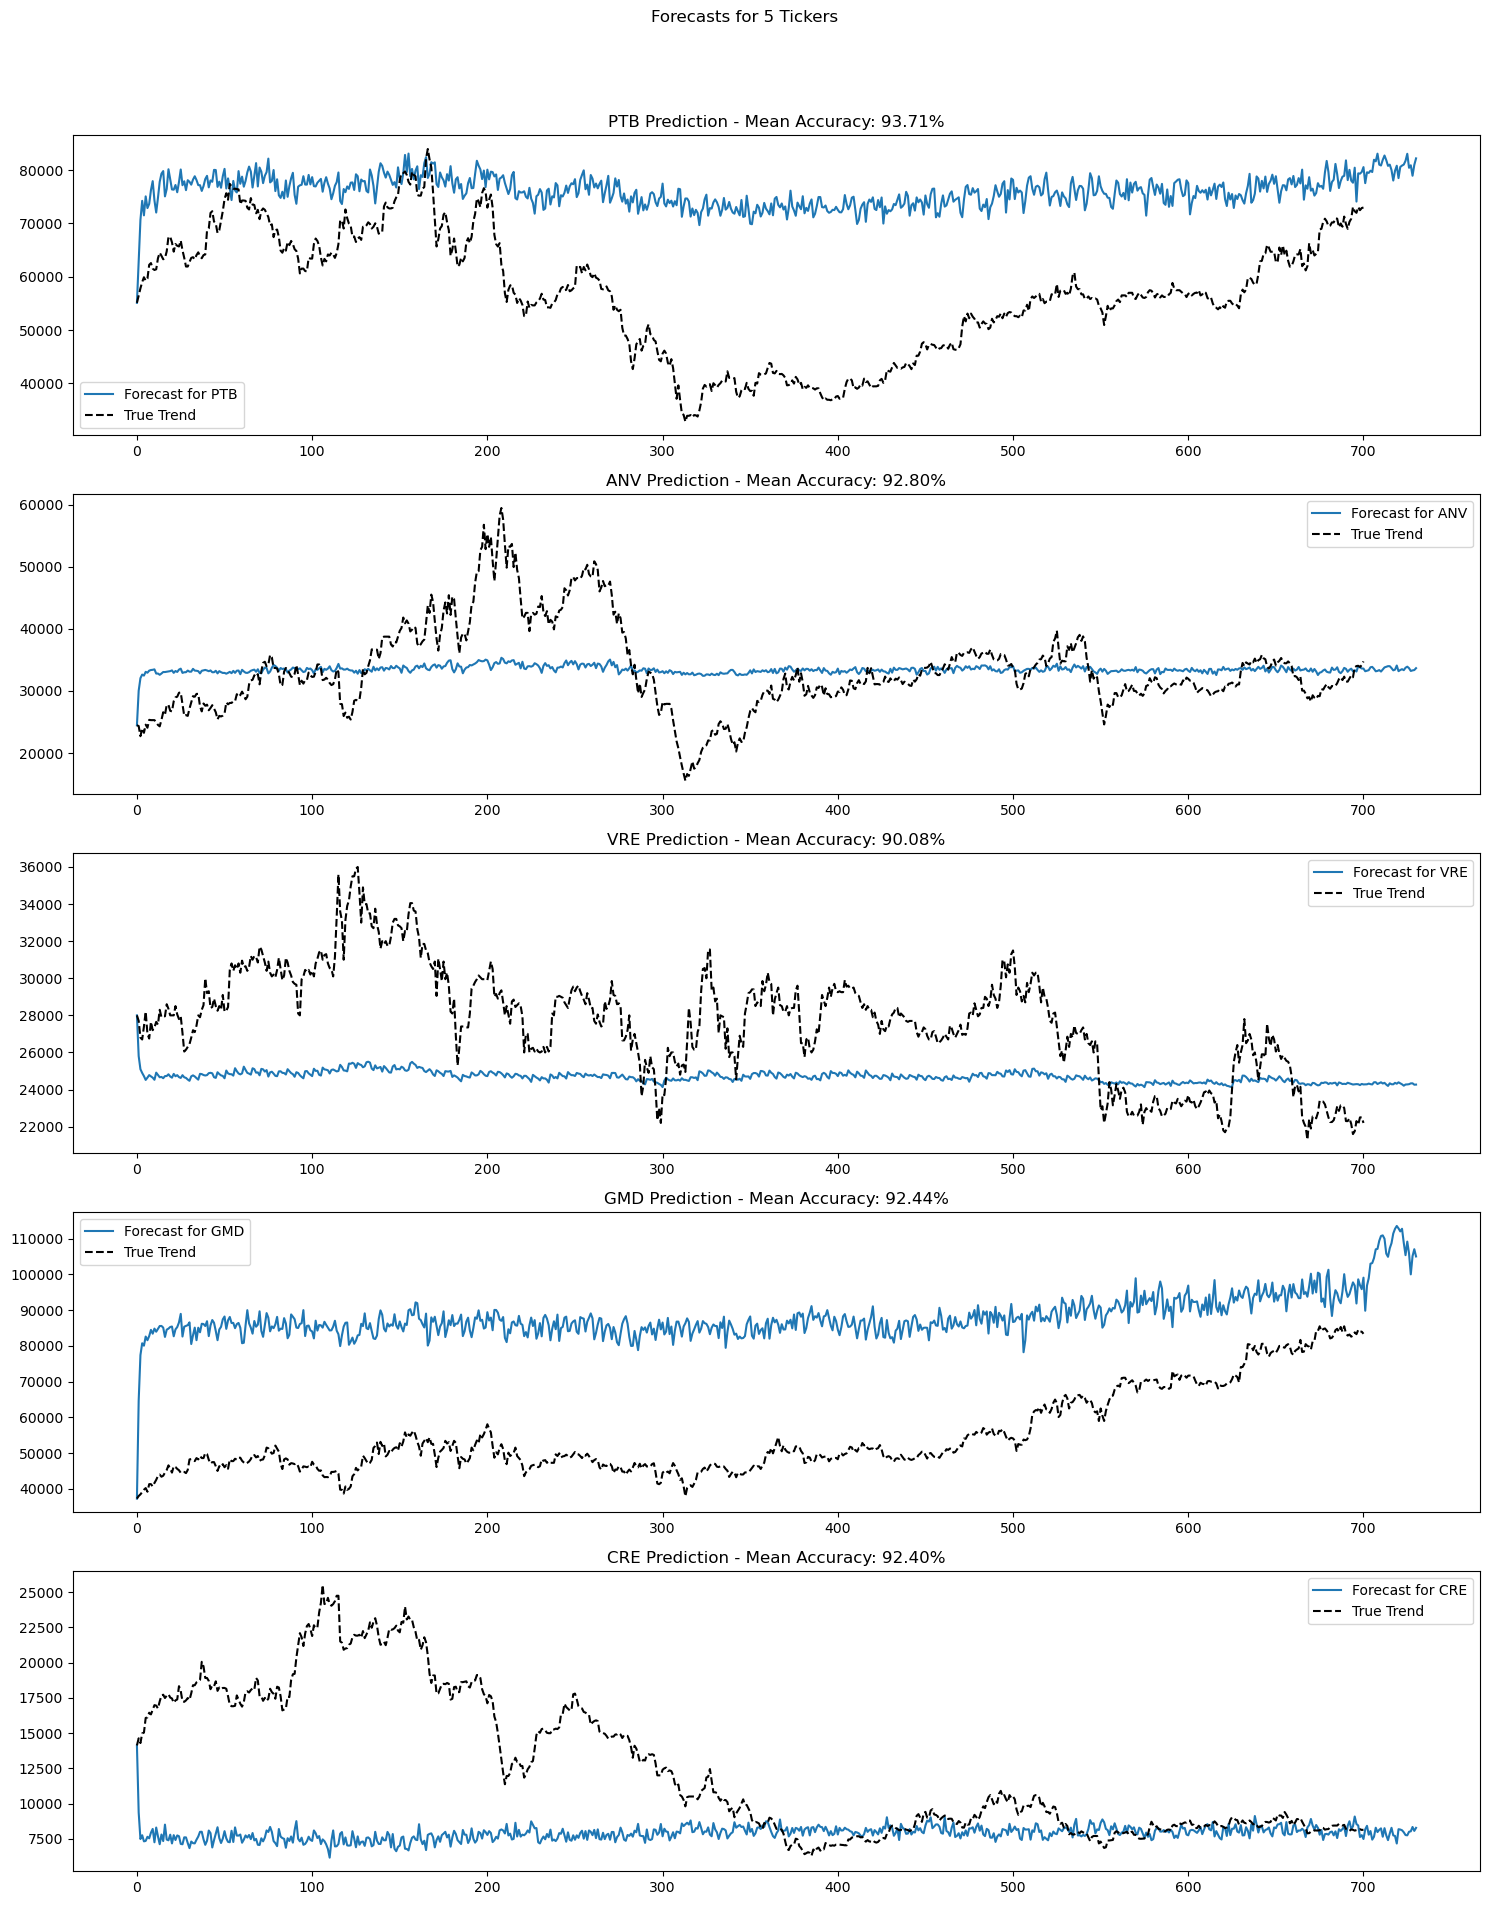

In [47]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
fig.suptitle('Forecasts for 5 Tickers')

for idx, column in enumerate(random_columns):
    new_df = df[[column]]
    minmax = MinMaxScaler().fit(new_df.astype('float32'))
    df_log = minmax.transform(new_df.astype('float32'))
    df_log = pd.DataFrame(df_log)
    df_train = df_log

    class Model:
        def __init__(
            self,
            learning_rate,
            num_layers,
            size,
            size_layer,
            output_size,
            forget_bias = 0.1,
            lambda_coeff = 0.5
        ):
            def lstm_cell(size_layer):
                return tf.nn.rnn_cell.GRUCell(size_layer)

            rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X = tf.placeholder(tf.float32, (None, None, size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
                rnn_cells, output_keep_prob = forget_bias
            )
            self.hidden_layer = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            _, last_state = tf.nn.dynamic_rnn(
                drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
            )
            
            self.z_mean = tf.layers.dense(last_state, size)
            self.z_log_sigma = tf.layers.dense(last_state, size)
            
            epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
            self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
            
            with tf.variable_scope('decoder', reuse = False):
                rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                    [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
                )
                drop_dec = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
                    rnn_cells_dec, output_keep_prob = forget_bias
                )
                x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
                self.outputs, self.last_state = tf.nn.dynamic_rnn(
                    drop_dec, self.X, initial_state = last_state, dtype = tf.float32
                )
                
            self.logits = tf.layers.dense(self.outputs[-1], output_size)
            self.lambda_coeff = lambda_coeff
            
            self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                                tf.exp(2 * self.z_log_sigma), 1)
            self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
            self.cost = tf.reduce_mean(tf.square(self.Y - self.logits) + self.kl_loss)
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
                self.cost
            )
            
    def calculate_accuracy(real, predict):
        real = np.array(real) + 1
        predict = np.array(predict) + 1
        percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
        return percentage * 100

    def anchor(signal, weight):
        buffer = []
        last = signal[0]
        for i in signal:
            smoothed_val = last * weight + (1 - weight) * i
            buffer.append(smoothed_val)
            last = smoothed_val
        return buffer
    
    def forecast():
        tf.reset_default_graph()
        modelnn = Model(
            learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
        )
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

        pbar = tqdm(range(epoch), desc = 'train loop')
        for i in pbar:
            init_value = np.zeros((1, num_layers * size_layer))
            total_loss, total_acc = [], []
            for k in range(0, df_train.shape[0] - 1, timestamp):
                index = min(k + timestamp, df_train.shape[0] - 1)
                batch_x = np.expand_dims(
                    df_train.iloc[k : index, :].values, axis = 0
                )
                batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
                batch_y = df_train.iloc[k + 1 : index + 1, :].values
                logits, last_state, _, loss = sess.run(
                    [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                    feed_dict = {
                        modelnn.X: batch_x,
                        modelnn.Y: batch_y,
                        modelnn.hidden_layer: init_value,
                    },
                )        
                init_value = last_state
                total_loss.append(loss)
                total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
        
        future_day = test_size

        output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
        output_predict[0] = df_train.iloc[0]
        upper_b = (df_train.shape[0] // timestamp) * timestamp
        init_value = np.zeros((1, num_layers * size_layer))

        for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
            out_logits, last_state = sess.run(
                [modelnn.logits, modelnn.last_state],
                feed_dict = {
                    modelnn.X: np.expand_dims(
                        df_train.iloc[k : k + timestamp], axis = 0
                    ),
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            output_predict[k + 1 : k + timestamp + 1] = out_logits

        if upper_b != df_train.shape[0]:
            out_logits, last_state = sess.run(
                [modelnn.logits, modelnn.last_state],
                feed_dict = {
                    modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                    modelnn.hidden_layer: init_value,
                },
            )
            output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
            future_day -= 1
            date_ori.append(date_ori[-1] + timedelta(days = 1))

        init_value = last_state
        
        for i in range(future_day):
            o = output_predict[-future_day - timestamp + i:-future_day + i]
            out_logits, last_state = sess.run(
                [modelnn.logits, modelnn.last_state],
                feed_dict = {
                    modelnn.X: np.expand_dims(o, axis = 0),
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            output_predict[-future_day + i] = out_logits[-1]
            date_ori.append(date_ori[-1] + timedelta(days = 1))
        
        output_predict = minmax.inverse_transform(output_predict)
        deep_future = anchor(output_predict[:, 0], 0.3)
        mean_accuracy = np.mean(total_acc)
        return deep_future, mean_accuracy
    
    for i in range(simulation_size):
        print(f'Simulation {i+1} for column: {column}')
        forecast_results, accuracy = forecast()
        results.append(forecast_results)

    # Plot results for each column
    axes[idx].plot(forecast_results, label=f'Forecast for {column}')
    axes[idx].plot(new_df.values, label='True Trend', color='black', linestyle='--')
    axes[idx].legend()
    axes[idx].set_title(f'{column} Prediction - Mean Accuracy: {accuracy:.2f}%')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()